# Titanic Classification Problem
What we have here is a dataset on the 1912 Titanic disaster. It's a binary classification problem where the labels represent a passenger's survival. This Notebook is an attempt to apply machine learning techniques to build a model capable of accurately predicting whether a passenger survives or not, based on factors such as ticket class, gender, age, etc.

## Imports
Firstly, we need to get housekeeping out of the way by importing the usual suspects.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

## Loading the Data
The next step is to load the data. It's in a folder called 'data' and already separated into train and test .csv's. I'll load them into pandas dataframes and take a look at how the data looks like.

In [2]:
fname_train = "./data/train_titanic.csv"
fname_test = "./data/test_titanic.csv"
train = pd.read_csv(fname_train)
test = pd.read_csv(fname_test)

In [3]:
train.shape, test.shape

((891, 12), (418, 11))

Well then.. Looks like the test data doesn't have labels included and we'll have to rely on cross validation scores to pick a model. I'll then use that final model to submit predictions on Kaggle and report the scores here.

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Right off the bat, I can see some columns probably irrelevant in the context of machine learning, e.g. Name and Cabin. I'll get around to removing them when building the model. But first, I'd like to visualize some of the data and take a look at the distribution. Also, the column names can get abit confusing so I'll rename some of them here.

In [6]:
train = train.rename(index=str, columns={'PassengerId': 'Id',
                                 'Pclass': 'TicketClass',
                                 'SibSp': 'SiblingsSpouses',
                                 'Parch': 'ParentsChildren'})
test = test.rename(index=str, columns={'PassengerId': 'Id',
                                'Pclass': 'TicketClass',
                                'SibSp': 'SiblingsSpouses',
                                'Parch': 'ParentsChildren'})

### Labels
This is a simple 0 or 1 binary value on whether the passenger survives the disaster or not. According to Google, ~68% of people on board the Titanic did not, but this dataset appears to only hold 891 passengers.

In [7]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

 That's 61% dead passengers. Not exactly a 50/50 split, but not overly skewed to make it worthy of feature engineering.

## Visualization
### Gender & Age
From James Cameron's movie, we should expect women and children more likely to survive. Let's see if this is true. First, the theory that there are proportionally more women survivors than men:

In [8]:
data = train.copy()

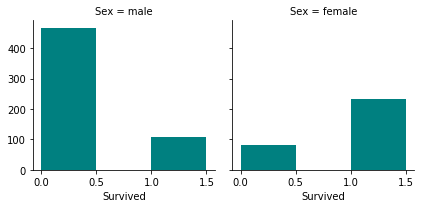

In [9]:
graph = sns.FacetGrid(data,
                      col='Sex')
graph.map(plt.hist, 
          'Survived',
          bins=[0,0.5,1,1.5],
          color='teal')

Sure enough, not only are there more female passengers who survived over males, but there are also far more female survivors than ones that didn't survive. The men however, suffer the exact opposite. There are over three times as many males who perished than survived. What about children? We should expect to see the same case with them:

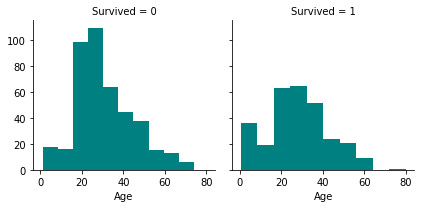

In [10]:
graph = sns.FacetGrid(data, col='Survived')
graph.map(plt.hist,
          'Age',
          color='teal')

This is interesting on both ends of the age spectrum. There are more children and elderly survivors than casualties, while passengers aged 20-50 experience more casualties. Rightfully so, since the saying usually goes "women, children and elderly first".

### Ticket Class
Another thing worth looking into should be the breakdown of survivors by their ticket class. One might expect first class passengers were given priority on life boats, as portrayed in the movie. Let's see if that holds true in real life:

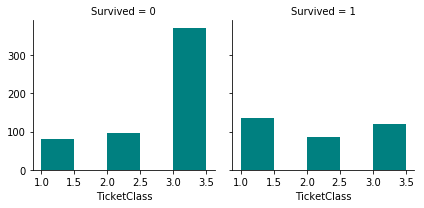

In [11]:
graph = sns.FacetGrid(data, col='Survived')
graph.map(plt.hist,
          'TicketClass',
          bins=[1,1.5,2,2.5,3,3.5],
          color='teal')

Looking solely at the number of survivors, the count looks pretty even, with all three classes hovering around 80-120 survivors. But taking into account the number of actual passengers for each, there is a way higher proportion of first class passengers who survived than third class. In fact, there are 3 times as many third class passenger casualties than survivors, while first class passengers have more survivors than deaths. I expect this to be a significant indicator when modeling the data later on.

## Preparing the Data
Some tidying up should be done to help with model convergence. I'll start by removing irrelevant features like Id, Cabin, etc. I'm kind of unsure whether Embarked matters at all for the model but will keep it in for now. If the information gain from it is low, I'll drop it when training future models.

In [12]:
train = train.drop(columns=['Id','Name','Ticket','Cabin'])
test = test.drop(columns=['Id','Name','Ticket','Cabin'])

In [13]:
train.head(0)

,Survived,TicketClass,Sex,Age,SiblingsSpouses,ParentsChildren,Fare,Embarked


I also need to convert Sex and Embarked into numerical values. Since Sex is binary, I can simply change them to 0's and 1's. For Embarked however, I'll have to one-hot-encode the values and add the binary columns Cherbourg, Queenstown and Southampton. The same will be done on the test set.

In [14]:
# Training set
train['Sex'][train['Sex'] == 'male'] = 1
train['Sex'][train['Sex'] == 'female'] = 0
cherb = train['Embarked'].copy()
cherb[cherb == 'C'] = 1
cherb[cherb != 1] = 0
queens = train['Embarked'].copy()
queens[queens == 'Q'] = 1
queens[queens != 1] = 0
south = train['Embarked'].copy()
south[south == 'S'] = 1
south[south != 1] = 0
train = train.drop(['Embarked'], axis=1)
train['Cherbourg'] = cherb
train['Queenstown'] = queens
train['Southampton'] = south

# Test set
test['Sex'][test['Sex'] == 'male'] = 1
test['Sex'][test['Sex'] == 'female'] = 0
cherb = test['Embarked'].copy()
cherb[cherb == 'C'] = 1
cherb[cherb != 1] = 0
queens = test['Embarked'].copy()
queens[queens == 'Q'] = 1
queens[queens != 1] = 0
south = test['Embarked'].copy()
south[south == 'S'] = 1
south[south != 1] = 0
test = test.drop(['Embarked'], axis=1)
test['Cherbourg'] = cherb
test['Queenstown'] = queens
test['Southampton'] = south

train.head()

,Survived,TicketClass,Sex,Age,SiblingsSpouses,ParentsChildren,Fare,Cherbourg,Queenstown,Southampton
0,0,3,1,22.0,1,0,7.2500,0,0,1
1,1,1,0,38.0,1,0,71.2833,1,0,0
2,1,3,0,26.0,0,0,7.9250,0,0,1
3,1,1,0,35.0,1,0,53.1000,0,0,1
4,0,3,1,35.0,0,0,8.0500,0,0,1


Dealing with missing values comes next. I'll have to find columns with NaN's and decide how to handle these missing values. First, let's see which one of these has missing values.

In [15]:
for col in train.columns:
    print("Train Data - ", col, ": ", train[col].isnull().values.any())
for col in test.columns:
    print("Test Data - ", col, ": ", test[col].isnull().values.any())

Train Data -  Survived :  False
Train Data -  TicketClass :  False
Train Data -  Sex :  False
Train Data -  Age :  True
Train Data -  SiblingsSpouses :  False
Train Data -  ParentsChildren :  False
Train Data -  Fare :  False
Train Data -  Cherbourg :  False
Train Data -  Queenstown :  False
Train Data -  Southampton :  False
Test Data -  TicketClass :  False
Test Data -  Sex :  False
Test Data -  Age :  True
Test Data -  SiblingsSpouses :  False
Test Data -  ParentsChildren :  False
Test Data -  Fare :  True
Test Data -  Cherbourg :  False
Test Data -  Queenstown :  False
Test Data -  Southampton :  False


Only Age has missing values for training data, while test has Age and Fare with NaN's. I'll treat both by replacing them with the mean values since the number of samples is already small and we can't afford simply dropping them.

In [16]:
avg = train['Age'].mean()
train['Age'][train['Age'].isnull()] = avg
avg = test['Age'].mean()
test['Age'][test['Age'].isnull()] = avg
avg = test['Fare'].mean()
test['Fare'][test['Fare'].isnull()] = avg

## Training
Training will be done using cross validation on the training set. For now, that will be 15% of the data. To facilitate easy replication of results, I'll also set a random_state whenever necessary. I'll then decide on the model with the highest validation score to generate test predictions from the testing set. These predictions will then be submitted on Kaggle's site.

### Validation Data
For the sake of consistency, I'll generate validation indices here and use the same one for all models.

In [17]:
train_X, valid_X, train_Y, valid_Y = train_test_split(train.drop(['Survived'], axis=1),
                                                      train['Survived'],
                                                      test_size=0.15,
                                                      stratify=train['Survived'])

valid_X and valid_Y (not to be confused with the test data) will be the data used to score each generated model. These will be the same throughout all testing, which should help allow for some measure of consistency.

### Decision Trees
I'll start with decision trees and go from there. That way, I can rebuild the tree without Embarked if the initial one gives a low score on its information gain. To find the best hyperparameters, I'll also do a rudimentary form of a grid search by looping over some values for each parameter then keeping the best scoring model.

#### Embarked or no Embarked?
A quick check to see if Embarked should be included or not.

In [18]:
dt = DecisionTreeClassifier(random_state=5)
dt.fit(train_X, train_Y)
dt.feature_importances_

array([0.10997486, 0.29505985, 0.28100758, 0.04339923, 0.01633061,
       0.23128225, 0.00659903, 0.00386169, 0.01248489])

All three of the embarkation columns have around 1% importance. I think it's safe to say we can drop them.

In [19]:
train_X = train_X.drop(['Cherbourg','Queenstown','Southampton'], axis=1)
valid_X = valid_X.drop(['Cherbourg','Queenstown','Southampton'], axis=1)
test = test.drop(['Cherbourg','Queenstown','Southampton'], axis=1)

In [20]:
dt_best_model = DecisionTreeClassifier()
dt_best_score = 0
leafs = [1, 2, 5, 10]
crit = ['gini', 'entropy']
split = ['best']
for l in leafs:
    for c in crit:
        for s in split:
            dt = DecisionTreeClassifier(min_samples_leaf=l, 
                                        criterion=c,
                                        splitter=s,
                                        random_state=5)
            dt.fit(train_X, train_Y)
            score = dt.score(valid_X, valid_Y)
            if score > dt_best_score:
                dt_best_model = dt
                dt_best_score = score
dt_best_score, dt_best_model.get_params()

(0.835820895522388,
 {'class_weight': None,
  'criterion': 'gini',
  'max_depth': None,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_impurity_split': None,
  'min_samples_leaf': 5,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'presort': False,
  'random_state': 5,
  'splitter': 'best'})

The best performing model used criterion='gini', splitter='best' and min_samples_leaf=10. This means that the Gini Index does better than information gain and having 10 points per leaf produces a stronger model. That said, I believe the scores are pretty close for some combinations, especially when tweaking min_samples_leaf but I'll keep this model for argument's sake.

Now let's take a look at other learners and see if they do any better.


#### Neural Network
This one has a bunch of parameters to look at: hidden_layer_sizes, activation, solver, alpha, momentum, learning_rate_init are all worth tuning.

In [21]:
nn_best_model = MLPClassifier()
nn_best_score = 0
layers = [(l,)*size for size in [1,2,3] for l in [3,6,9,12]]
act = ['tanh','relu']
slv = ['sgd','adam']
alp = [10**a for a in range(-4,0)]
mom = [0.1, 0.5, 1]
lrate = [k*10**a for k in [5,9] for a in range(-4,0)]
for l in layers:
    for ac in act:
        for s in slv:
            for al in alp:
                for m in mom:
                    for lr in lrate:
                        nn = MLPClassifier(hidden_layer_sizes=l,
                                           activation=ac,
                                           solver=s,
                                           alpha=al,
                                           momentum=m,
                                           learning_rate_init=lr,
                                           max_iter=5000,
                                           random_state=5)
                        nn.fit(train_X, train_Y)
                        score = nn.score(valid_X, valid_Y)
                        if score > nn_best_score:
                            nn_best_model = nn
                            nn_best_score = score
nn_best_score, nn_best_model.get_params()

(0.8507462686567164,
 {'activation': 'tanh',
  'alpha': 0.1,
  'batch_size': 'auto',
  'beta_1': 0.9,
  'beta_2': 0.999,
  'early_stopping': False,
  'epsilon': 1e-08,
  'hidden_layer_sizes': (6,),
  'learning_rate': 'constant',
  'learning_rate_init': 0.009000000000000001,
  'max_iter': 5000,
  'momentum': 0.1,
  'nesterovs_momentum': True,
  'power_t': 0.5,
  'random_state': 5,
  'shuffle': True,
  'solver': 'adam',
  'tol': 0.0001,
  'validation_fraction': 0.1,
  'verbose': False,
  'warm_start': False})

Looks like the neural network model slightly outperformed the decision tree. Considering neural nets are all the buzz nowadays, that's nice to see it living up to the hype even though it isn't necessarily deep learning. What's interesting to note is that the hidden layer the for the NN model has a three hidden layers of size 12, which is actually larger than the number of features.

#### Logistic Regression
The logit model is up next. I'd expect this to do pretty well considering this is a binary classification problem. Since there aren't many hyperparameters to work with, I'll try both L1 and L2 regularization for the sake of completion.

In [22]:
logit_best_model = LogisticRegression()
logit_best_score = 0
reg = ['l1', 'l2']
slvr = ['liblinear', 'saga']
for r in reg:
    for s in slvr:
        logit = LogisticRegression(penalty=r, 
                                   solver=s, 
                                   max_iter=5000, 
                                   random_state=5)
        logit.fit(train_X, train_Y)
        score = logit.score(valid_X, valid_Y)
        if score > logit_best_score:
            logit_best_model = logit
            logit_best_score = score
logit_best_score, logit_best_model.get_params()

(0.8432835820895522,
 {'C': 1.0,
  'class_weight': None,
  'dual': False,
  'fit_intercept': True,
  'intercept_scaling': 1,
  'max_iter': 5000,
  'multi_class': 'ovr',
  'n_jobs': 1,
  'penalty': 'l1',
  'random_state': 5,
  'solver': 'liblinear',
  'tol': 0.0001,
  'verbose': 0,
  'warm_start': False})

#### Random Forest
Considering the small training set, I could see the random forest model outperforming the decision tree. But it would be interesting to see if it matches the neural network. Again, there are slightly more parameters to tweak here.

In [23]:
rf_best_model = RandomForestClassifier()
rf_best_score = 0
estimators = [5, 10, 20]
crit = ['entropy', 'gini']
leafs = [1, 2, 5, 10]
feats = [x for x in range(1, train.shape[1]-3)] + ['auto']
for e in estimators:
    for c in crit:
        for l in leafs:
            for f in feats:
                rf = RandomForestClassifier(n_estimators=e, 
                                            criterion=c, 
                                            min_samples_leaf=l, 
                                            max_features=f, 
                                            random_state=5)
                rf.fit(train_X, train_Y)
                score = rf.score(valid_X, valid_Y)
                if score > rf_best_score:
                    rf_best_model = rf
                    rf_best_score = score
rf_best_score, rf_best_model.get_params()

(0.8955223880597015,
 {'bootstrap': True,
  'class_weight': None,
  'criterion': 'entropy',
  'max_depth': None,
  'max_features': 3,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_impurity_split': None,
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 10,
  'n_jobs': 1,
  'oob_score': False,
  'random_state': 5,
  'verbose': 0,
  'warm_start': False})

Look at that.. Pretty decent for a random learner. The best parameters are in line with the single tree learner, both performing better with criterion='gini' and min_samples_leaf=10. What sets this apart from the single tree is the bootstrapping of 20 learners to use their average, reducing the odds of overfitting!

#### Support Vector Machine
The most time-consuming model of the group, but worth considering since we have a binary classification problem. What allows this learner to do well depends on whether the data is linearly separable. My guess is no, because chance and happenstance would have played a big part in a passenger's survival. In other words, the passenger is not guaranteed a survivor if they were X age and was in first class.

In [24]:
svm_best_model = SVC()
svm_best_score = 0
kern = ['rbf', 'linear', 'sigmoid', 'poly']
for k in kern:
    svm = SVC(kernel = k, 
              max_iter=10000, 
              random_state=5)
    svm.fit(train_X, train_Y)
    score = svm.score(valid_X, valid_Y)
    if score > svm_best_score:
        svm_best_model = svm
        svm_best_score = score
svm_best_score, svm_best_model.get_params()

(0.7761194029850746,
 {'C': 1.0,
  'cache_size': 200,
  'class_weight': None,
  'coef0': 0.0,
  'decision_function_shape': 'ovr',
  'degree': 3,
  'gamma': 'auto',
  'kernel': 'linear',
  'max_iter': 10000,
  'probability': False,
  'random_state': 5,
  'shrinking': True,
  'tol': 0.001,
  'verbose': False})

As expected, the SVM does not do very well. This proves my theory that the data is not linearly separable and hence support vector machines struggle to properly classify surviving passengers from the Titanic disaster.

#### K-Nearest Neighbors
The only lazy learner of the bunch, the kNN model feels like a coin toss to me. It has the potential to do well if the passengers tended to flock with one another, and hence have a higher chance of seeing the same outcome. On the other hand, if this doesn't hold true then the model should do poorly, which is the more likely scenario.

In [25]:
knn_best_model = KNeighborsClassifier()
knn_best_score = 0
neighbors = [x for x in range(1,11)]
wgts = ['uniform', 'distance']
power = [x for x in range(1, 5)]
for k in neighbors:
    for w in wgts:
        for pow in power:
            knn = KNeighborsClassifier(n_neighbors=k, 
                                       weights=w, 
                                       p=pow)
            knn.fit(train_X, train_Y)
            score = knn.score(valid_X, valid_Y)
            if score > knn_best_score:
                knn_best_model = knn
                knn_best_score = score
knn_best_score, knn_best_model.get_params()

(0.8134328358208955,
 {'algorithm': 'auto',
  'leaf_size': 30,
  'metric': 'minkowski',
  'metric_params': None,
  'n_jobs': 1,
  'n_neighbors': 5,
  'p': 1,
  'weights': 'distance'})

Surprise surprise.. k-NN suffers the same issues with the SVM model. The randomness of passengers' survival does not help a purely deterministic learner.

#### Short Disclaimer:
Running the entire kernel multiple times actually leads to a toss-up between the random forest or neural network as the best model. But for the sake of this exercise I'll stick to the neural net.

### Best Model
Turns out the neural net does best! 87% accuracy is a rather respectable result. But is that better than random? To do that, I'll have to check the Kappa Statistic.

In [26]:
from sklearn.metrics import cohen_kappa_score
y1 = nn_best_model.predict(valid_X)
y2 = valid_Y
cohen_kappa_score(y1, y2)

0.6760937877689147

That value corresponds to a decently good model. Now to generate a new model with the validation data included for training then submit the predictions on Kaggle. I decided to re-include the validation data because every instance matters with a training size of 891.

In [ ]:
train_X = train_X.append(valid_X)
train_Y = train_Y.append(valid_Y)

In [33]:
submission_model = RandomForestClassifier(n_estimators=10, 
                                          criterion='entropy', 
                                          min_samples_leaf=2, 
                                          max_features='auto')
submission_model.fit(train_X, train_Y)

In [34]:
submission = pd.Series(submission_model.predict(test))
indices = pd.Series([x for x in range(892, 1310)])

submission = pd.concat([indices, submission], axis=1)
submission.columns = ['PassengerId', 'Survived']
submission.set_index('PassengerId')
submission.to_csv('submission.csv')

I got 0.7751 for my submission. Not as good as I'd like. One day I'll come back to this with and see what else I can do. My early suspicions is there needs to be much more feature engineering before training the model. 6 features feels too little for my liking.